# Assignment 1
###  Manuel Bolduc
### 260788246

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math

### Poisson Solver Implementation on a square

In [5]:
#finite element definition
#We want to define finite element triangles 
#by their corresponding nodes in a square
#We work in cartesian coordinates x,y
def elem3sq(x,y):
    xshape=x.shape[0]
    n=2*(xshape-1)**2 #number of finite elements in a convex square
    p=np.zeros([xshape-1,2*(xshape-1),3])
    for i in range(xshape-1):
        for j in range(2*(xshape-1)):
            k=i*(xshape)+np.floor(j/2)
            if j%2==0:
                p[i,j,:]=[k,k+1,k+xshape]
            else:
                p[i,j,:]=[k+1,k+xshape,k+xshape+1]
    p=np.reshape(p,(n,3))
    p=np.array(p,dtype='int')
    return p


In [28]:
#Throughout the definition of the various functions, 4 main variables 
#will appear: x,y,ninit,n (or nnow). The first two are obviously the 
#possible nodes coordinates. The latter two are used for refining the 
#grid. ninit represents the initial number of finite elements, and n (nnow) 
#represents the actual number of finite elements. 

#Here are my initial test functions: u(x)=sin(x+y), f(x)=2*sin(x+y)
def utrue(x,y,ninit,n):
    u=np.zeros([len(x),len(y)])
    for i in range(len(x)):
        for j in range(len(y)):
            u[i,j]=np.sin((x[i]+y[j])*ninit/n) #definition of the solution   
    return u
def f(x,y,ninit,n):
    return 2*utrue(x,y,ninit,n) 

def g(a,b,ninit,n):
    return 2*np.sin((a+b)*ninit/n) #g is u on the square boundary



#Stiffness Matrix for one triangle
#(following the work of Alberty, J. et al.) (p.122)
def stima3(M):
    g=np.array([[0,0],[1,0],[0,1]])
    G=np.dot(np.linalg.inv(M),g)
    stima=np.abs(np.linalg.det(M))*np.dot(G,G.transpose())/2
    return stima

# area of one triangle divided by two
def M(xx,yy,vertices):
    d=2
    M=np.ones([d+1,d+1])
    M[1,:]=xx.flatten()[vertices]
    M[2,:]=yy.flatten()[vertices]
    return M

# Mass matrix (Will be useful to compute error norms) 
#Again, this is following the work of Alberty, J. et al.)(p.127)
def massmatrix(M):
    G=np.array([[2,1,1],[1,2,1],[1,1,2]])
    return 1/24*np.abs(np.linalg.det(M))*G

#Dirichlet Boundary conditions on the square
#We have g=u on the boundary and 0 in the interior.
def dirichletbc(x,y,ninit,n):
    uguess=np.zeros([len(x),len(y)])
    uguess[0,:]=utrue(x,y,ninit,n)[0,:]
    uguess[-1,:]=utrue(x,y,ninit,n)[-1,:]
    uguess[:,0]=utrue(x,y,ninit,n)[:,0]
    uguess[:,-1]=utrue(x,y,ninit,n)[:,-1]
    uflat=uguess.flatten()
    return uflat #flattened to implement in the b vector later on

#Assembly of full stiffness matrix, b vector and mass matrix
#We simply add up the matrices defined for single elements into a bigger
#matrix of size n (the number of nodes).
def matrixassembly(x,y,ninit,nnow):
    elem3=elem3sq(x,y)
    n=x.shape[0]**2
    xx,yy=np.meshgrid(x,y)
    xx=xx*ninit/nnow
    yy=yy*ninit/nnow
    A=np.zeros([n,n])
    MassMatrix=np.zeros([n,n])
    b=np.zeros([n])
    #Stiffness Matrix
    for i in range(2*(x.shape[0]-1)**2):
        for j in range(3):
            A[elem3[i,:],elem3[i,j]]=A[elem3[i,:],elem3[i,j]]+stima3(M(xx,yy,elem3[i,:]))[j]
    
    #b vector
    for i in range(2*(x.shape[0]-1)**2):
        b[elem3[i,:]]=b[elem3[i,:]]+np.abs(np.linalg.det(M(xx,yy,elem3[i,:])))*g(np.sum(xx.flatten()[elem3[i,:]])/3.0,np.sum(yy.flatten()[elem3[i,:]])/3.0,1,1)/6

    b=b.transpose()-np.dot(A,dirichletbc(x,y,ninit,nnow))
    
    #Mass matrix
    for i in range(2*(x.shape[0]-1)**2):
        for j in range(3):
            MassMatrix[elem3[i,:],elem3[i,j]]=MassMatrix[elem3[i,:],elem3[i,j]]+massmatrix(M(xx,yy,elem3[i,:]))[j]
    return A, b, MassMatrix

# This function gathers all interior nodes in the square
def findfreenodes(x,y):
    freenodes=[]
    xx,yy=np.meshgrid(x,y)
    xx=xx.flatten()
    yy=yy.flatten()
    for i in range(len(xx)):
        if xx[i]>0 and xx[i]<len(x)-1:
            if yy[i]>0 and yy[i]<len(x)-1:
                freenodes.append(i)        
    return freenodes

#All the functions defined earlier are then called by solver(x,y,ninit,n)
#This function returns the numerical approximation to the solution of the
#boundary value problem on a grid of size nxn.
def solver(x,y,ninit,n):
    fn=findfreenodes(x,y)
    Afree=np.zeros([len(fn),len(fn)])
    A,b,mass=matrixassembly(x,y,ninit,n)
    uflat=dirichletbc(x,y,ninit,n)
    for i in range(len(fn)):
        Afree[0:len(fn),i]=A[fn,fn[i]]

    bfree=b[fn]
    uflat[fn]=np.dot(np.linalg.inv(Afree),bfree)
    ufound=np.reshape(uflat,(len(x),len(y)))
    return ufound

#This function is used to refine the grid
def redrefinement(x,y):
    xup=np.linspace(x[0],2*x[-1],2*x.shape[0]-1)
    yup=np.linspace(y[0],2*y[-1],2*y.shape[0]-1)
    return xup,yup



### Numerical Experiments part 1,2, and 3

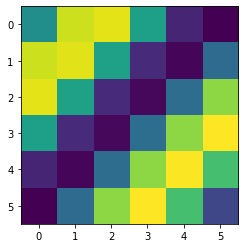

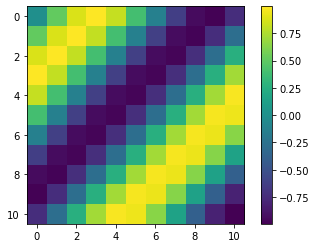

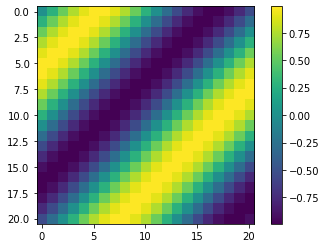

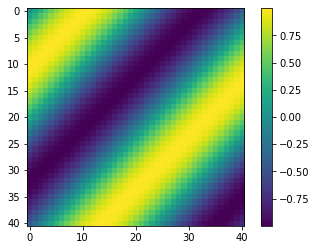

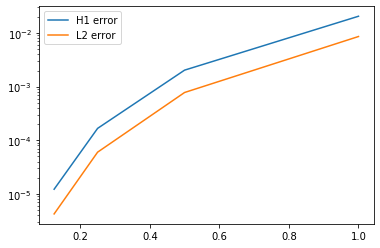

In [29]:
#Initialize the H1 error and L2 error
l2err=np.zeros([4])
h1err=np.zeros([4])

#Initialize x and y
x=np.linspace(0,5,6)
y=x

#ninit is simply the shape of x (or y)
ninit=x.shape[0]

#n initially is n init
n=x.shape[0]

#solve for initial parameters
ufound=solver(x,y,ninit,n)
plt.imshow(ufound)
plt.pause(0.1)

#Define the true solution
utruee=utrue(x,y,ninit,n)
utruee=utruee

#Define the error vector
v=np.abs(utruee.flatten()-ufound.flatten())

#We run the matrixassembly function to compute the H1 and L2 norms
A,b,Mass=matrixassembly(x,y,ninit,n)

#L2 error is given by v^{T}*M*v
l2err[0]=np.dot(v.transpose(),np.dot(Mass,v))

#H1 error is fiven by v^{T}*M*v+v^{T}*A*v 
h1err[0]=np.dot(v.transpose(),np.dot(Mass,v))+np.dot(v.transpose(),np.dot(A,v))

#Repeat for a decreasing gridsize (we divide the gridsize in 2 each time)
for k in range(3):
    n=2*n-1
    xup,yup=redrefinement(x,y)
    ufound=solver(xup,yup,ninit,n)
    ufound=ufound
    plt.imshow(ufound)
    plt.colorbar()
    utruee=utrue(xup,yup,ninit,n)
    utruee=utruee
    v=np.abs(utruee.flatten()-ufound.flatten())
    A,b,Mass=matrixassembly(xup,yup,ninit,n)
    l2err[k+1]=np.dot(v.transpose(),np.dot(Mass,v))
    h1err[k+1]=np.dot(v.transpose(),np.dot(Mass,v))+np.dot(v.transpose(),np.dot(A,v))
    plt.pause(0.1)
    x=xup
    y=yup
    
    
h=[1,1/2,1/4,1/8] #distance between nodes

#Plot
plt.plot(h,h1err,label='H1 error')
plt.plot(h,l2err,label='L2 error')
plt.yscale("log")
plt.legend()



In [36]:
#Order of convergence of the H1 error
alpha=0
for i in range(3):
    alpha+=np.log(np.abs((h1err[i+1]-h1err[i])))/np.log(np.abs(h[i+1]-h[i]))
alpha/3

4.836145637874689

In [38]:
#Order of convergence of the L2 error
alpha=0
for i in range(3):
    alpha+=np.log(np.abs((l2err[i+1]-l2err[i])))/np.log(np.abs(h[i+1]-h[i]))
alpha/3

5.643063851650591

We observe that the L2 error converges faster than H1, which is consistent with theory. 

## Part 4: L Shape Implementation

In the following cell, I basically implement the same functions as for the convex shape, except that I must take into account the different formulation of the boundary conditions. To implement the L shape, I basically implemented the solver method for three convex squares, and I tweaked the boundaries.

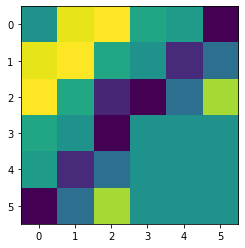

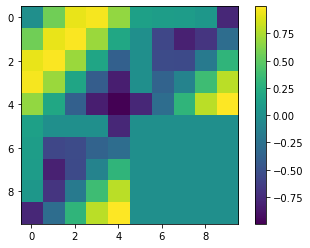

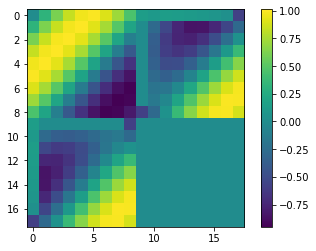

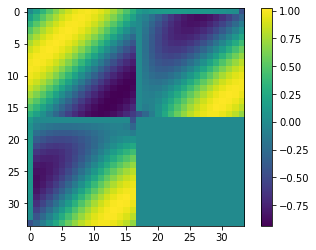

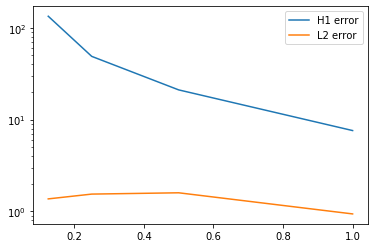

In [44]:
#Lshapeimplementation
#Starting from a square, I generate some sort of L shape

def Lshape(x,y):
    xL=np.append(x,x+len(x))
    xL=np.append(xL,x)
    yL=np.append(y,y)
    yL=np.append(yL,y+len(y))
    xxL=np.append(np.meshgrid(x,y)[0],np.meshgrid(x+len(x),y)[0])
    xxL=np.append(xxL,np.meshgrid(x,y)[0])
    yyL=np.append(np.meshgrid(x,y)[1],np.meshgrid(x,y)[1])
    yyL=np.append(yyL,np.meshgrid(x,y+len(y))[1])
    return xL,yL,xxL,yyL

def uL(x,y):
    return np.zeros([2*len(x),2*len(y)])
#Here are my initial test functions: u(x)=sin(x+y), f(x)=2*sin(x+y)
#Same as before, except I define u over three different squares.
def uLtrue(x,y,ninit,n):
    u=uL(x,y)
    xL,yL,xxL,yyL=Lshape(x,y)
    
    for i in range(len(x)):
        for j in range(len(y)):
            u[i,j]=np.sin((xL[i]+yL[j])*ninit/n)
    for i in range(len(x),2*len(x)):
        for j in range(len(y)):
            u[i,j]=np.sin((xL[i]+yL[j])*ninit/n)
    for i in range(len(x)):
        for j in range(len(y),2*len(y)):
            u[i,j]=np.sin((xL[i+len(x)]+yL[j])*ninit/n)
    return u

#The next functions are exactly as before
def f(x,y,ninit,n):
    return 2*uLtrue(x,y,ninit,n)

def g(a,b,ninit,n):
    return 2*np.sin((a+b)*ninit/n)

def M(xx,yy,vertices):
    d=2
    M=np.ones([d+1,d+1])
    M[1,:]=xx.flatten()[vertices]
    M[2,:]=yy.flatten()[vertices]
    return M

def stima3(M):
    g=np.array([[0,0],[1,0],[0,1]])
    G=np.dot(np.linalg.inv(M),g)
    stima=np.abs(np.linalg.det(M))*np.dot(G,G.transpose())/2
    return stima

def massmatrix(M):
    G=np.array([[2,1,1],[1,2,1],[1,1,2]])
    return 1/24*np.abs(np.linalg.det(M))*G

#To implement the L shape boundary conditions, I consider a fourth square
#filled with zeros where the corner would be. The rest follows naturally.
def Lshapedirichletbc(x,y,ninit,n):
    uguess=np.zeros([2*len(x),2*len(y)])
    uguess[0,:]=uLtrue(x,y,ninit,n)[0,:]
    uguess[-1,:]=uLtrue(x,y,ninit,n)[-1,:]
    uguess[:,0]=uLtrue(x,y,ninit,n)[:,0]
    uguess[:,-1]=uLtrue(x,y,ninit,n)[:,-1]
    uguess[len(x)-1:,len(x)-1:]=uLtrue(x,y,ninit,n)[len(x)-1:,len(x)-1:]
    uflat=uguess[:len(x),:len(x)].flatten()
    uflat=np.append(uflat,uguess[len(x):,:len(x)].flatten())
    uflat=np.append(uflat,uguess[:len(x),len(x):].flatten())
    return uflat

#This function returns the triangle nodes. I first find the nodes for the
#triangles inside the three different squares. Then, I add the extra elements
#lying at the junction of the squares.
def elem3Lsh(x,y):
    xshape=x.shape[0]
    nl=np.max(elem3sq(x,y))
    n=2*(x.shape[0]-1)**2
    p=elem3sq(x,y)
    p=np.append(np.append(p,p+nl+1),p+2*nl+2)
    
    extra=4*(xshape-1)
    pextra=np.zeros([extra,3])
    for i in range(extra):
        if i<extra/2:
            if i%2==0:
                pextra[i,:]=[(i/2+1)*(xshape)-1,(i/2+2)*(xshape)-1,(i/2+xshape)*xshape]
            else:
                pextra[i,:]=[((i+1)/2+1)*(xshape)-1,((i-1)/2+xshape)*xshape,((i+1)/2+xshape)*xshape]
                
        else:
            if i%2==0:
                k=i-int(extra/2)
                pextra[i,:]=[(xshape-1)*xshape+k/2,(xshape-1)*xshape+k/2+1,2*nl+2+k/2]
            else:
                k=i-int(extra/2)
                pextra[i,:]=[(xshape-1)*xshape+(k+1)/2,2*nl+2+(k+1)/2-1,2*nl+2+(k+1)/2]
    p=np.append(p,pextra)
    p=np.reshape(p,(3*n+extra,3))
    p=np.array(p,dtype='int')
    return p

#Same as in Part 1
def Lshapematrixassembly(x,y,ninit,nnow):
    elem3=elem3Lsh(x,y)
    nl=3*x.shape[0]**2
    n=3*2*(x.shape[0]-1)**2+4*(x.shape[0]-1)
    xl,yl,xxl,yyl=Lshape(x,y)
    xx,yy=np.meshgrid(x,y)
    xxl=xxl*ninit/nnow
    yyl=yyl*ninit/nnow
    A=np.zeros([nl,nl])
    MassMatrix=np.zeros([nl,nl])
    b=np.zeros([nl])
    for i in range(n):
        for j in range(3):
            A[elem3[i,:],elem3[i,j]]=A[elem3[i,:],elem3[i,j]]+stima3(M(xxl,yyl,elem3[i,:]))[j]

    for i in range(n):
        b[elem3[i,:]]=b[elem3[i,:]]+np.abs(np.linalg.det(M(xxl,yyl,elem3[i,:])))*g(np.sum(xxl.flatten()[elem3[i,:]])/3.0,np.sum(yyl.flatten()[elem3[i,:]])/3.0,1,1)/6

    b=b.transpose()-np.dot(A,Lshapedirichletbc(x,y,ninit,nnow))
    
    for i in range(n):
        for j in range(3):
            MassMatrix[elem3[i,:],elem3[i,j]]=MassMatrix[elem3[i,:],elem3[i,j]]+massmatrix(M(xxl,yyl,elem3[i,:]))[j]
    return A, b, MassMatrix

# there's new possibilities for free nodes now at boundaries of the squares.
def Lshapefindfreenodes(x,y):
    freenodes=[]
    xl,yl,xxl,yyl=Lshape(x,y)
    xx,yy=np.meshgrid(x,y)
    xxl=xxl.flatten()
    yyl=yyl.flatten()
    for i in range(len(xxl)):
        if xxl[i]>0 and xxl[i]<(2*len(x)-1):
            if yyl[i]>0 and yyl[i]<(2*len(x)-1):
                if xxl[i]!=(len(x)-1) and yyl[i]!=(len(x)-1):
                    freenodes.append(i)  
                elif xxl[i]==(len(x)-1):
                    if yyl[i]<(len(x)-1):
                        freenodes.append(i)
                elif yyl[i]==(len(x)-1):
                    if xxl[i]<(len(x)-1):
                        freenodes.append(i)
    return freenodes

def Lsolver(x,y,ninit,n):
    fn=Lshapefindfreenodes(x,y)
    Afree=np.zeros([len(fn),len(fn)])
    A,b,mass=Lshapematrixassembly(x,y,ninit,n)
    uflat=Lshapedirichletbc(x,y,ninit,n)
    for i in range(len(fn)):
        Afree[0:len(fn),i]=A[fn,fn[i]]

    bfree=b[fn]
    uflat[fn]=np.dot(np.linalg.inv(Afree),bfree)
    ufound=np.zeros([2*len(x),2*len(y)])
    ufound[:len(x),:len(y)]=np.reshape(uflat[:len(x)**2],(len(x),len(y)))
    ufound[len(x):,:len(y)]=np.reshape(uflat[len(x)**2:2*len(x)**2],(len(x),len(y)))
    ufound[:len(x),len(y):]=np.reshape(uflat[2*len(x)**2:3*len(x)**2],(len(x),len(y)))
    return ufound


# We repeat the computation for the L2 and H1 error on grids with 
# decreasing mesh sizes.

l2err=np.zeros([4])
h1err=np.zeros([4])
x=np.linspace(0,2,3)
y=x
ninit=x.shape[0]
n=x.shape[0]
ufound=Lsolver(x,y,ninit,n)
plt.imshow(ufound)
plt.pause(0.1)
utruee=uLtrue(x,y,ninit,n)
utruee=utruee
v=np.abs(utruee.flatten()-ufound.flatten())[:3*n**2]
A,b,Mass=Lshapematrixassembly(x,y,ninit,n)
l2err[0]=np.dot(v.transpose(),np.dot(Mass,v))
h1err[0]=np.dot(v.transpose(),np.dot(Mass,v))+np.dot(v.transpose(),np.dot(A,v))
for k in range(3):
    n=2*n-1
    xup,yup=redrefinement(x,y)
    ufound=Lsolver(xup,yup,ninit,n)
    ufound=ufound
    plt.imshow(ufound)
    plt.colorbar()
    utruee=uLtrue(xup,yup,ninit,n)
    utruee=utruee
    v=np.abs(utruee.flatten()-ufound.flatten())[:3*n**2]
    A,b,Mass=Lshapematrixassembly(xup,yup,ninit,n)
    l2err[k+1]=np.dot(v.transpose(),np.dot(Mass,v))
    h1err[k+1]=np.dot(v.transpose(),np.dot(Mass,v))+np.dot(v.transpose(),np.dot(A,v))
    plt.pause(0.1)
    x=xup
    y=yup
    
h=[1,1/2,1/4,1/8] #distance between nodes
plt.plot(h,h1err,label='H1 error')
plt.plot(h,l2err,label='L2 error')
plt.yscale("log")
plt.legend()



Clearly, something is going wrong with my implementation of the L shape. I am not exactly sure what is happening, but it seems as the lines of data located at the junctions between the squares are staying at 0. This is clearly what is driving the H1 error and L2 error to grow as the mesh size decreases. 

## Part 5: $r^{a}\sin(a\theta)$

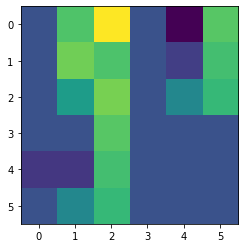

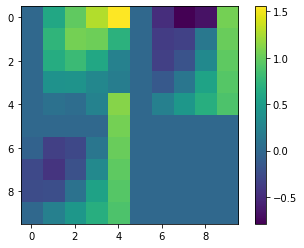

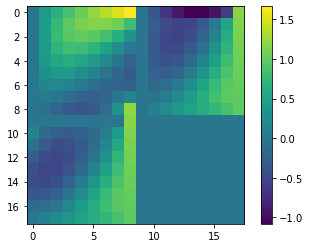

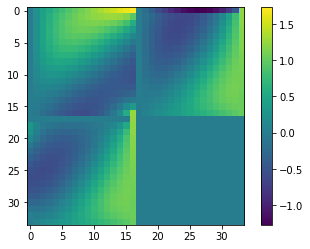

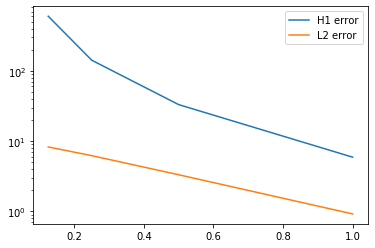

In [48]:
#we simply change our initial function and use the same code as before. 



def Lshape(x,y):
    xL=np.append(x,x+len(x))
    xL=np.append(xL,x)
    yL=np.append(y,y)
    yL=np.append(yL,y+len(y))
    xxL=np.append(np.meshgrid(x,y)[0],np.meshgrid(x+len(x),y)[0])
    xxL=np.append(xxL,np.meshgrid(x,y)[0])
    yyL=np.append(np.meshgrid(x,y)[1],np.meshgrid(x,y)[1])
    yyL=np.append(yyL,np.meshgrid(x,y+len(y))[1])
    return xL,yL,xxL,yyL

def uL(x,y):
    return np.zeros([2*len(x),2*len(y)])
#Here are my initial test functions: u(x)=sin(x+y), f(x)=2*sin(x+y)
#Same as before, except I define u over three different squares.
def r(x,y):
    r=np.sqrt(x**2+y**2)
    return r
def theta(x,y):
    return np.arctan2(y,x)

def uLtrue(x,y,ninit,n):
    a=2/3
    u=uL(x,y)
    xL,yL,xxL,yyL=Lshape(x,y)
    xL=xL*ninit/n
    yL=yL*ninit/n
    for i in range(len(x)):
        for j in range(len(y)):
            u[i,j]=r(xL[i],yL[j])**a*np.sin(a*theta(xL[i],yL[j]))
    for i in range(len(x),2*len(x)):
        for j in range(len(y)):
            u[i,j]=r(xL[i],yL[j])**a*np.sin(a*theta(xL[i],yL[j]))
    for i in range(len(x)):
        for j in range(len(y),2*len(y)):
            u[i,j]=r(xL[i+len(x)],yL[j])**a*np.sin(a*theta(xL[i+len(x)],yL[j]))
    return u

#The next functions are exactly as before
def f(x,y,ninit,n):
    return 2*uLtrue(x,y,ninit,n)

def g(a,b,ninit,n):
    return 2*np.sin((a+b)*ninit/n)

def M(xx,yy,vertices):
    d=2
    M=np.ones([d+1,d+1])
    M[1,:]=xx.flatten()[vertices]
    M[2,:]=yy.flatten()[vertices]
    return M

def stima3(M):
    g=np.array([[0,0],[1,0],[0,1]])
    G=np.dot(np.linalg.inv(M),g)
    stima=np.abs(np.linalg.det(M))*np.dot(G,G.transpose())/2
    return stima

def massmatrix(M):
    G=np.array([[2,1,1],[1,2,1],[1,1,2]])
    return 1/24*np.abs(np.linalg.det(M))*G

#To implement the L shape boundary conditions, I consider a fourth square
#filled with zeros where the corner would be. The rest follows naturally.
def Lshapedirichletbc(x,y,ninit,n):
    uguess=np.zeros([2*len(x),2*len(y)])
    uguess[0,:]=uLtrue(x,y,ninit,n)[0,:]
    uguess[-1,:]=uLtrue(x,y,ninit,n)[-1,:]
    uguess[:,0]=uLtrue(x,y,ninit,n)[:,0]
    uguess[:,-1]=uLtrue(x,y,ninit,n)[:,-1]
    uguess[len(x)-1:,len(x)-1:]=uLtrue(x,y,ninit,n)[len(x)-1:,len(x)-1:]
    uflat=uguess[:len(x),:len(x)].flatten()
    uflat=np.append(uflat,uguess[len(x):,:len(x)].flatten())
    uflat=np.append(uflat,uguess[:len(x),len(x):].flatten())
    return uflat

#This function returns the triangle nodes. I first find the nodes for the
#triangles inside the three different squares. Then, I add the extra elements
#lying at the junction of the squares.
def elem3Lsh(x,y):
    xshape=x.shape[0]
    nl=np.max(elem3sq(x,y))
    n=2*(x.shape[0]-1)**2
    p=elem3sq(x,y)
    p=np.append(np.append(p,p+nl+1),p+2*nl+2)
    
    extra=4*(xshape-1)
    pextra=np.zeros([extra,3])
    for i in range(extra):
        if i<extra/2:
            if i%2==0:
                pextra[i,:]=[(i/2+1)*(xshape)-1,(i/2+2)*(xshape)-1,(i/2+xshape)*xshape]
            else:
                pextra[i,:]=[((i+1)/2+1)*(xshape)-1,((i-1)/2+xshape)*xshape,((i+1)/2+xshape)*xshape]
                
        else:
            if i%2==0:
                k=i-int(extra/2)
                pextra[i,:]=[(xshape-1)*xshape+k/2,(xshape-1)*xshape+k/2+1,2*nl+2+k/2]
            else:
                k=i-int(extra/2)
                pextra[i,:]=[(xshape-1)*xshape+(k+1)/2,2*nl+2+(k+1)/2-1,2*nl+2+(k+1)/2]
    p=np.append(p,pextra)
    p=np.reshape(p,(3*n+extra,3))
    p=np.array(p,dtype='int')
    return p

#Same as in Part 1
def Lshapematrixassembly(x,y,ninit,nnow):
    elem3=elem3Lsh(x,y)
    nl=3*x.shape[0]**2
    n=3*2*(x.shape[0]-1)**2+4*(x.shape[0]-1)
    xl,yl,xxl,yyl=Lshape(x,y)
    xx,yy=np.meshgrid(x,y)
    xxl=xxl*ninit/nnow
    yyl=yyl*ninit/nnow
    A=np.zeros([nl,nl])
    MassMatrix=np.zeros([nl,nl])
    b=np.zeros([nl])
    for i in range(n):
        for j in range(3):
            A[elem3[i,:],elem3[i,j]]=A[elem3[i,:],elem3[i,j]]+stima3(M(xxl,yyl,elem3[i,:]))[j]

    for i in range(n):
        b[elem3[i,:]]=b[elem3[i,:]]+np.abs(np.linalg.det(M(xxl,yyl,elem3[i,:])))*g(np.sum(xxl.flatten()[elem3[i,:]])/3.0,np.sum(yyl.flatten()[elem3[i,:]])/3.0,1,1)/6

    b=b.transpose()-np.dot(A,Lshapedirichletbc(x,y,ninit,nnow))
    
    for i in range(n):
        for j in range(3):
            MassMatrix[elem3[i,:],elem3[i,j]]=MassMatrix[elem3[i,:],elem3[i,j]]+massmatrix(M(xxl,yyl,elem3[i,:]))[j]
    return A, b, MassMatrix

# there's new possibilities for free nodes now at boundaries of the squares.
def Lshapefindfreenodes(x,y):
    freenodes=[]
    xl,yl,xxl,yyl=Lshape(x,y)
    xx,yy=np.meshgrid(x,y)
    xxl=xxl.flatten()
    yyl=yyl.flatten()
    for i in range(len(xxl)):
        if xxl[i]>0 and xxl[i]<(2*len(x)-1):
            if yyl[i]>0 and yyl[i]<(2*len(x)-1):
                if xxl[i]!=(len(x)-1) and yyl[i]!=(len(x)-1):
                    freenodes.append(i)  
                elif xxl[i]==(len(x)-1):
                    if yyl[i]<(len(x)-1):
                        freenodes.append(i)
                elif yyl[i]==(len(x)-1):
                    if xxl[i]<(len(x)-1):
                        freenodes.append(i)
    return freenodes

def Lsolver(x,y,ninit,n):
    fn=Lshapefindfreenodes(x,y)
    Afree=np.zeros([len(fn),len(fn)])
    A,b,mass=Lshapematrixassembly(x,y,ninit,n)
    uflat=Lshapedirichletbc(x,y,ninit,n)
    for i in range(len(fn)):
        Afree[0:len(fn),i]=A[fn,fn[i]]

    bfree=b[fn]
    uflat[fn]=np.dot(np.linalg.inv(Afree),bfree)
    ufound=np.zeros([2*len(x),2*len(y)])
    ufound[:len(x),:len(y)]=np.reshape(uflat[:len(x)**2],(len(x),len(y)))
    ufound[len(x):,:len(y)]=np.reshape(uflat[len(x)**2:2*len(x)**2],(len(x),len(y)))
    ufound[:len(x),len(y):]=np.reshape(uflat[2*len(x)**2:3*len(x)**2],(len(x),len(y)))
    return ufound


# We repeat the computation for the L2 and H1 error on grids with 
# decreasing mesh sizes.

l2err=np.zeros([4])
h1err=np.zeros([4])
x=np.linspace(0,2,3)
y=x
ninit=x.shape[0]
n=x.shape[0]
ufound=Lsolver(x,y,ninit,n)
plt.imshow(ufound)
plt.pause(0.1)
utruee=uLtrue(x,y,ninit,n)
utruee=utruee
v=np.abs(utruee.flatten()-ufound.flatten())[:3*n**2]
A,b,Mass=Lshapematrixassembly(x,y,ninit,n)
l2err[0]=np.dot(v.transpose(),np.dot(Mass,v))
h1err[0]=np.dot(v.transpose(),np.dot(Mass,v))+np.dot(v.transpose(),np.dot(A,v))
for k in range(3):
    n=2*n-1
    xup,yup=redrefinement(x,y)
    ufound=Lsolver(xup,yup,ninit,n)
    ufound=ufound
    plt.imshow(ufound)
    plt.colorbar()
    utruee=uLtrue(xup,yup,ninit,n)
    utruee=utruee
    v=np.abs(utruee.flatten()-ufound.flatten())[:3*n**2]
    A,b,Mass=Lshapematrixassembly(xup,yup,ninit,n)
    l2err[k+1]=np.dot(v.transpose(),np.dot(Mass,v))
    h1err[k+1]=np.dot(v.transpose(),np.dot(Mass,v))+np.dot(v.transpose(),np.dot(A,v))
    plt.pause(0.1)
    x=xup
    y=yup
    
h=[1,1/2,1/4,1/8] #distance between nodes
plt.plot(h,h1err,label='H1 error')
plt.plot(h,l2err,label='L2 error')
plt.yscale("log")
plt.legend()




Again, there is a weird issue at the junction between the squares